## Reconnaissance des émotions des tweets : Traitement du langage naturel avec TensorFlow

---

Ensemble de données : [Ensemble de données d'émotions des tweets](https://github.com/dair-ai/emotion_dataset)

---


## Configuration et importations

1. Importation des bibliothèques
2. Définition des fonctions utiles


In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import load_dataset



# show accuracy and loss of train data and validation data trainings
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# show confusion matrix between true and predicted labels
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

2024-02-06 15:07:32.657074: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 15:07:34.898255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 15:07:34.898357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 15:07:35.229040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 15:07:35.936909: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 15:07:35.938255: I tensorflow/core/platform/cpu_feature_guard.cc:1

Using TensorFlow version 2.15.0


## Importation des données

1. Importation de l'ensemble de données d'émotions des tweets
2. Création des ensembles d'entraînement, de validation et de test
3. Extraction des tweets et des étiquettes à partir des exemples


In [2]:
classes_string={0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
dataset = load_dataset('emotion')

/home/codespace/.python/current/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [5]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets, labels

In [6]:
tweets, labels = get_tweet(train)

In [30]:
for i in range(5):
  print(f"('{tweets[i]}', '{classes_string[labels[i]]}')")

('i didnt feel humiliated', 'sadness')
('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'sadness')
('im grabbing a minute to post i feel greedy wrong', 'anger')
('i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'love')
('i am feeling grouchy', 'anger')


## Tokenizer

1. Tokenisation des tweets


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [10]:
print(tweets[1])
tokenizer.texts_to_sequences([tweets[1]])

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

## Remplissage et troncature des séquences

1. Vérification de la longueur des tweets
2. Création de séquences remplies


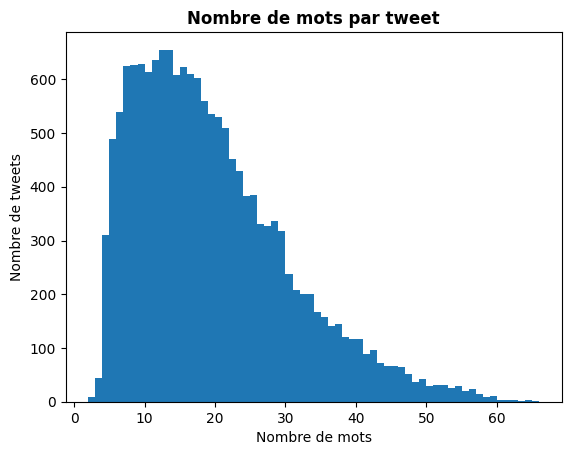

In [33]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.title("Nombre de mots par tweet", fontweight="bold")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de tweets")
plt.show()

In [12]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [14]:
padded_train_seq=get_sequences(tokenizer, tweets)

In [15]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Préparation des étiquettes

1. Création des dictionnaires de correspondance entre les classes et les index, et entre les index et les classes
2. Conversion des étiquettes textuelles en étiquettes numériques


In [16]:
# classes_string=["sadness", "joy", "love", "anger", "fear", "surprise"]
classes=set(labels)
print(classes_string[classes])

{0, 1, 2, 3, 4, 5}


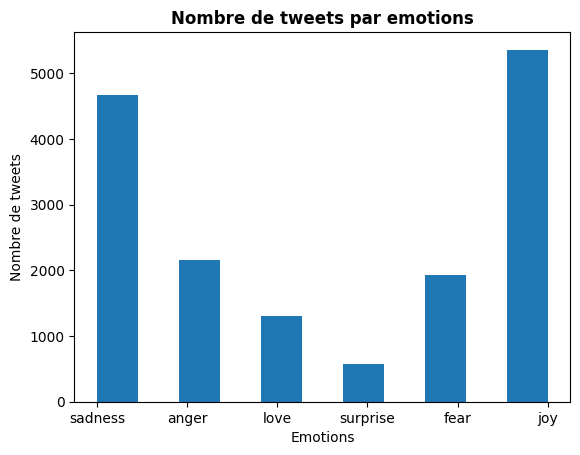

In [37]:
label_strings = [classes_string[label] for label in labels]
plt.hist(label_strings, bins=11)
plt.title("Nombre de tweets par emotions", fontweight="bold")
plt.xlabel("Emotions")
plt.ylabel("Nombre de tweets")
plt.show()

In [18]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [21]:
names_to_indexes=lambda labels: np.array([class_to_index.get(x) for x in labels ])

In [22]:
train_labels=names_to_indexes(labels)

## Création du modèle

1. Création du modèle
2. Compilation du modèle


In [41]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),
  tf.keras.layers.Dense(6, activation='softmax')
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_12 (Bidirect  (None, 50, 40)            5920      
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 50, 40)            9760      
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, 40)                9760      
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 6)                 246       
                                                      

## Entraînement du modèle

1. Préparation d'un ensemble de validation
2. Entraînement du modèle


In [26]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_indexes(val_labels)

In [27]:
val_labels

array([0, 0, 2, ..., 1, 1, 1])

In [46]:
# Define the path to save/load the model
model_path = './model.tf'

# Check if the model file exists
if os.path.exists(model_path):
  # Load the model if it exists
  model = keras.models.load_model(model_path)
else:
  # Train the model if the model file does not exist
  hypothesis = model.fit(
    x=padded_train_seq,
    y=train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
  )
  # Save the trained model
  model.save(model_path)
  show_history(hypothesis)

## Évaluation du modèle

1. Visualisation de l'historique de l'entraînement
2. Préparation d'un ensemble de test
3. Un aperçu des prédictions individuelles sur l'ensemble de test
4. Un aperçu de toutes les prédictions sur l'ensemble de test


In [48]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_indexes(test_labels)

In [49]:
_ = model.evaluate(x=test_sequences, y=test_labels)

63/63 [==============================] - 2s 9ms/step - loss: 0.4365 - accuracy: 0.8710


In [53]:
input_tweet = input("Enter a tweet to predict its emotion: ")

maxlen = 50  # Adjust this to match the maxlen used during training
preprocessed_tweet = get_sequences(tokenizer, [input_tweet])

i_prediction = model.predict(preprocessed_tweet)[0]
predicted_class = index_to_class[np.argmax(i_prediction).astype('uint8')]


print(f'\nTweet : {input_tweet}')
print(f'Predicted Emotion : {classes_string[predicted_class]}')

1/1 [==============================] - 0s 16ms/step

Tweet : i am sad
Predicted Emotion : sadness


In [69]:
predictions = model.predict(test_sequences)
predicted_classes = np.argmax(predictions, axis=1)
string_predicted_classes = [classes_string[p] for p in predicted_classes]

24/63 [==========>...................] - ETA: 0s

63/63 [==============================] - 1s 9ms/step


array([0, 0, 0, ..., 1, 1, 4])

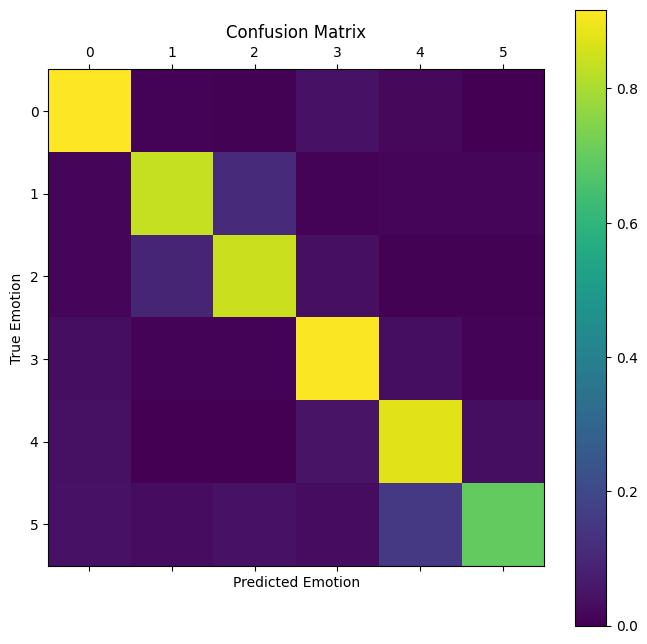

In [72]:
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(y_true, y_pred, classes):
  
  cm = confusion_matrix(y_true, y_pred, normalize='true')

  plt.figure(figsize=(8, 8))
  sp = plt.subplot(1, 1, 1)
  ctx = sp.matshow(cm)
  plt.xticks(list(range(0, len(classes))), labels=classes)
  plt.yticks(list(range(0, len(classes))), labels=classes)
  plt.colorbar(ctx)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Emotion")
  plt.ylabel("True Emotion")
  plt.show()

show_confusion_matrix(test_labels, predicted_classes, list(classes))